# RNN with LSTM for Predictive Traffic

In [1]:
import time
import math
import random

import os
import glob
import csv
import datetime

import numpy as np
import torch
import torch.nn as nn

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


## Preparing the data

In [3]:
# Traffic count and speed limit
count_limit = 150
speed_limit = 40

# CSV folder
folder = '210226_Daten_Hackathon/210226_Daten_Verkehr_Hackathon/'

# CSV files
files = os.listdir(folder)

# Traffic data of the direction
class TrafficData:
    # Traffic data
    time = []
    hour = []
    weekday = []
    week_number = []

    count = []
    speed = []
    speed_sum = []
    density = []

    def __init__(self, direction):
        self.direction = direction

    # Adds traffic data to the direction
    def add_data(self, time, speed):
        if(time in self.time):
            index = self.time.index(time)
            self.count[index] = self.count[index] + 1
            self.speed_sum[index] = self.speed_sum[index] + speed
        else:
            self.time.append(time)
            self.hour.append(time.hour)
            self.weekday.append(time.weekday)
            self.week_number.append(time.isocalendar()[1])

            self.count.append(1)
            self.speed_sum.append(speed)


# Traffic for each direction
traffic = {}

# Last read timestamp
last_time = 0

# Limits a value in an interval
def limit(value, min, max):
    if value < min:
        return min
    elif value > max:
        return max
    else:
        return value

# Maps a range of values to another
def map(value, min_in, max_in, min_out, max_out):
    scale = float(value - min_in) / float(max_in - min_in)
    scale = limit(scale, 0, 1)

    return (scale * float(max_out - min_out)) + min_out

# Read all CSV files
for file in files:

    # Open the CSV file
    with open(folder + file) as csv_file:
        # Read the CSV file with delimiter ';'
        csv_reader = csv.reader(csv_file, delimiter = ";")
        i = 0

        # Iterate through CSV rows
        for row in csv_reader:
            # Skip first 2 lines
            if i < 1:
                i = i + 1
                continue

            # Get parameters
            classification = row[0]
            confidence = int(row[1])
            direction = row[2]
            speed = int(row[3])
            time = datetime.datetime.strptime(row[4][:-3], '%d.%m.%Y %H')

            # Get current traffic instance
            if (direction in traffic) == False:
                traffic[direction] = TrafficData(direction)

            current = traffic[direction]

            # Add traffic data
            current.add_data(time, speed)

            # Set average speed
            if last_time != time:
                index = 0
                if last_time in current.time:
                    index = current.time.index(last_time)

                count = current.count[index]
                speed = current.speed_sum[index] / count
                density = (map(count, 0, count_limit, 0, 9) + map(speed, 0, speed_limit, 0, 9)) / 2

                current.speed.append(speed)
                current.density.append(density)
                last_time = time


data_traffic = traffic["Richtung A nach B"]
#array = np.array([data_traffic.density, data_traffic.hour, data_traffic.weekday, data_traffic.week_number])

In [4]:
# CSV file
file = '210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv'

# Weather data at a postcode
class WeatherData:
    # Weather data
    time = []
    hour = []
    weekday = []
    week_number = []

    temperature = []
    wind_speed = []
    precipitation = []
    radiation = []

    def __init__(self, postcode):
        self.postcode = postcode

    # Adds weather data to the postcode
    def add_data(self, time, temperature, wind_speed, precipitation, radiation):
        self.time.append(time)
        self.hour.append(time.hour)
        self.weekday.append(time.weekday())
        self.week_number.append(time.isocalendar()[1])

        self.temperature.append(temperature)
        self.wind_speed.append(wind_speed)
        self.precipitation.append(precipitation)
        self.radiation.append(radiation)


# Weather for each postcode
weather = {}

# Open the CSV file
with open(file) as csv_file:
    # Read the CSV file with delimiter ';'
    csv_reader = csv.reader(csv_file, delimiter = ";")
    i = 0

    # Iterate through CSV rows
    for row in csv_reader:
        # Skip first 2 lines
        if i < 2:
            i = i + 1
            continue

        # Get parameters
        time = datetime.datetime.strptime(row[0][:-3], '%d.%m.%Y %H')
        postcode = int(row[1])
        temperature = float(row[2].replace(",", "."))

        if row[3] == '':
            wind_speed = 0
        else:
            wind_speed = float(row[3].replace(",", "."))

        precipitation = float(row[4].replace(",", "."))
        radiation = float(row[5].replace(",", "."))

        # Get current weather instance
        if (postcode in weather) == False:
            weather[postcode] = WeatherData(postcode)

        current = weather[postcode]

        # Add wheather data
        current.add_data(time, temperature, wind_speed, precipitation, radiation)

data_weather = weather[76131]
#array = np.array([data_weather.temperature, data_weather.wind_speed, data_weather.precipitation, data_weather.radiation, data_weather.hour, data_weather.weekday, data_weather.week_number])

In [5]:
def traffic_to_tensor(data_traffic, zeitpunkt):
    
    """
    traffic_tensor() -> Tensor

    Returns a tensor which represents traffic density in retrospect of specific date

    """

    if (zeitpunkt in data_traffic.time) == True:
        i = data_traffic.time.index(zeitpunkt)
        x = data_traffic.density[i]
        x = int(x)

        traffic_tensor = torch.tensor([x], dtype=torch.long)

    else:
        # Falls Datum nicht gefunden wird
        traffic_tensor = torch.tensor([5])

    return traffic_tensor

def random_choice(a):
    # get random index from list
    random_idx = random.randint(0, a-1)
    return random_idx

def weather_to_tensor(data_weather, batch=1, input_size=7):
    
    """
    weather_to_tensor() -> Tensor, date

    Returns a random tensor of shape (seq_len, batch, input_size)

    Keywords:
        data - class whitch provides weather data
        batch - total number of training examples present in a single batch
        input_size - the number of expected features in the input x   
    """

    n_samples = len(data_weather.temperature)

    tensor = torch.zeros(1, batch, input_size)

    for i in range(batch):
        sample_index = random_choice(n_samples)
        #print(sample_index)

        tensor[0][i][0] = data_weather.temperature[sample_index]
        tensor[0][i][1] = data_weather.wind_speed[sample_index]
        tensor[0][i][2] = data_weather.precipitation[sample_index]
        tensor[0][i][3] = data_weather.radiation[sample_index]
        tensor[0][i][4] = data_weather.hour[sample_index]
        tensor[0][i][5] = data_weather.weekday[sample_index]
        tensor[0][i][6] = data_weather.week_number[sample_index]

    return tensor, data_weather.time[sample_index]

x, y  = weather_to_tensor(data_weather)
print(x)
print(y)

#traffic_tensor = torch.tensor([3], dtype=torch.long)
z = traffic_to_tensor(data_traffic, y) 
print(z, type(z))

tensor([[[ 18.6949,   7.1609,   2.2764, 396.1464,  13.0000,   2.0000,  25.0000]]])
2020-06-17 13:00:00
tensor([6]) <class 'torch.Tensor'>


## Defining network structure

In [6]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, n_layers, n_traffic):
        super(RNN, self).__init__()
        self.n_layers = n_layers
        self.hidden_size = hidden_size

        self.lstm = nn.LSTM(input_size, hidden_size, n_layers, batch_first=False)
        # -> x of shape (seq_len, batch, hidden_size)
        self.fc = nn.Linear(hidden_size, n_traffic)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        # initial hidden- & cell-state
        h0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)
        c0 = torch.zeros(self.n_layers, x.size(1), self.hidden_size).to(device)

        # output of shape (seq_len, batch, n_directions * hidden_size)
        out, _ = self.lstm(x, (h0,c0))
        
        # only last Time-Step
        out = out[-1, :, :]
        
        out = self.fc(out)
        out = self.softmax(out)

        return out

## Defining helper functions for neural networks's training

In [7]:
def train(weather_tensor, traffic_tensor):
    output = model(weather_tensor)
    loss = criterion(output, traffic_tensor)
    # traffic_tensor -> 
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return output, loss.item()

def traffic_from_output(output):
    traffic_idx = torch.argmax(output).item()
    return traffic_idx

## Defining hyperparameters of neural network's training

In [8]:
# hyper parameters
input_size = 7 # features
n_traffic = 10 # output_size
hidden_size = 128
n_layers = 1

learning_rate = 0.0001

## Start training loop

In [294]:
# initialize neural network   
model = RNN(input_size, hidden_size, n_layers, n_traffic).to(device)

# loss and optimizer
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

current_loss = 0
all_losses = []

print_every = 5000
plot_every = 1000
n_iters = 500000

#def timeSince(since):
    #now = time.time()
    #s = now - since
    #m = math.floor(s / 60)
    #s -= m * 60
    #return '%dm %ds' % (m, s)

#start = time.time()

for i in range(1, n_iters + 1):
    #character, file, character_tensor, file_tensor = random_training_example(character_files, all_characters)
    weather_tensor, zeitpunkt = weather_to_tensor(data_weather, 1, 7)
    traffic_tensor = traffic_to_tensor(data_traffic, zeitpunkt) 
    output, loss = train(weather_tensor.to(device), traffic_tensor.to(device))
    current_loss += loss
    
    # print iter number, loss, name and guess
    if i % print_every == 0:
        guess = traffic_from_output(output)
        correct = '✓' if guess == traffic_tensor.item() else '✗ (%s)' % traffic_tensor.item()
        #print('%d %d%% (%s) %.4f %s / %s %s' % (i, i / n_iters * 100, timeSince(start), loss, file, guess, correct))
        print('%d %d%% %.4f %s / %s %s' % (i, i / n_iters * 100, loss, file, guess, correct))

    # add current loss avg to list of losses
    if i % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 1% 1.2006 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 4 ✓
10000 2% 1.5311 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 5 ✗ (4)
15000 3% 1.3064 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 6 ✗ (5)
20000 4% 1.4178 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 5 ✗ (6)
25000 5% 3.3163 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 4 ✗ (6)
30000 6% 0.6176 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 5 ✓
35000 7% 1.1813 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 5 ✓
40000 8% 1.0866 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 5 ✗ (4)
45000 9% 1.3365 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 6 ✗ (5)
50000 10% 1.3715 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 5 ✗ (4)
55000 11% 1.3928 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 6 ✗ (5)
60000 12% 1.1038 210226_Daten_Hackathon/210226_Daten_Wetter_Hackathon.csv / 6 ✓
65000 13% 1.1059 2

## Plot LOSS-function

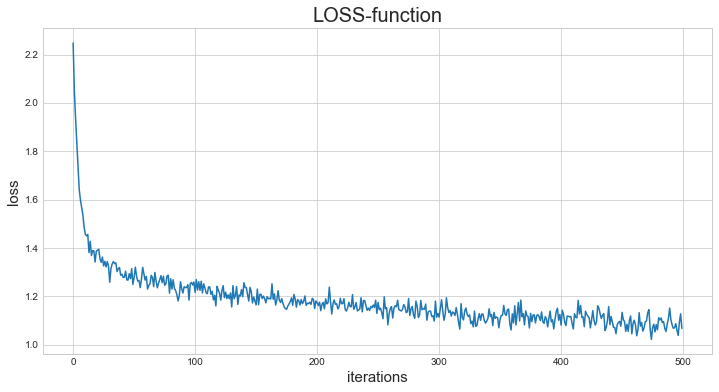

In [295]:
# create figure
mpl.style.use("seaborn-whitegrid")
plt.figure(figsize=(12,6))
# create plot
plt.plot(all_losses)
# title and labels
plt.title("LOSS-function", fontsize=20)
plt.xlabel("iterations", fontsize=15)
plt.ylabel("loss", fontsize=15)
# show plot
plt.show()

## Save model

In [296]:
FILE = "model.pth"
torch.save(model.state_dict(), FILE)

## Load Model

In [9]:
FILE = "model.pth"
loaded_model = RNN(input_size, hidden_size, n_layers, n_traffic).to(device)
loaded_model.load_state_dict(torch.load(FILE, map_location=device))
loaded_model.eval()

RNN(
  (lstm): LSTM(7, 128)
  (fc): Linear(in_features=128, out_features=10, bias=True)
  (softmax): LogSoftmax(dim=1)
)

## Determin accuracy


accuracy = 55.10 %



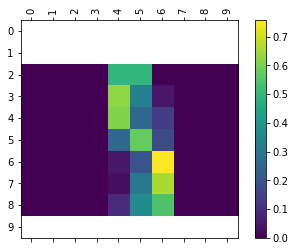

In [11]:
# keep track of correct guesses in a confusion matrix
confusion = torch.zeros(n_traffic, n_traffic)

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    
    for i in range(1000):
        weather_tensor, zeitpunkt = weather_to_tensor(data_weather, 1, 7)
        traffic_tensor = traffic_to_tensor(data_traffic, zeitpunkt)
        output = loaded_model(weather_tensor)

        guess = traffic_from_output(output)
        n_samples += 1

        if guess == traffic_tensor.item():
            n_correct += 1
            correct = "✓"
        else:
            correct = "✗ (%s)" % traffic_tensor.item()

        confusion[traffic_tensor.item()][guess] += 1
        #print(guess, correct)

# normalize by dividing every row by its sum
for i in range(n_traffic):
    confusion[i] = confusion[i] / confusion[i].sum()

acc = 100.0 * n_correct / n_samples
print(f"\naccuracy = {acc:.2f} %\n")

# set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

all_traffic = [0,1,2,3,4,5,6,7,8,9]

# set up axes
ax.set_xticklabels([''] + all_traffic, rotation=90)
ax.set_yticklabels([''] + all_traffic)

# force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()